In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import beamsim

# Set seaborn style for beautiful plots
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

run: mpirun -n 10 build/main -b ns3-direct -t direct -g 10 -gv 32 --report
run: mpirun -n 10 build/main -b ns3-direct -t gossip -g 10 -gv 32 --report
run: mpirun -n 10 build/main -b ns3-direct -t gossip -g 10 -gv 32 --report
run: mpirun -n 10 build/main -b ns3-direct -t grid -g 10 -gv 32 --report
run: mpirun -n 10 build/main -b ns3-direct -t grid -g 10 -gv 32 --report


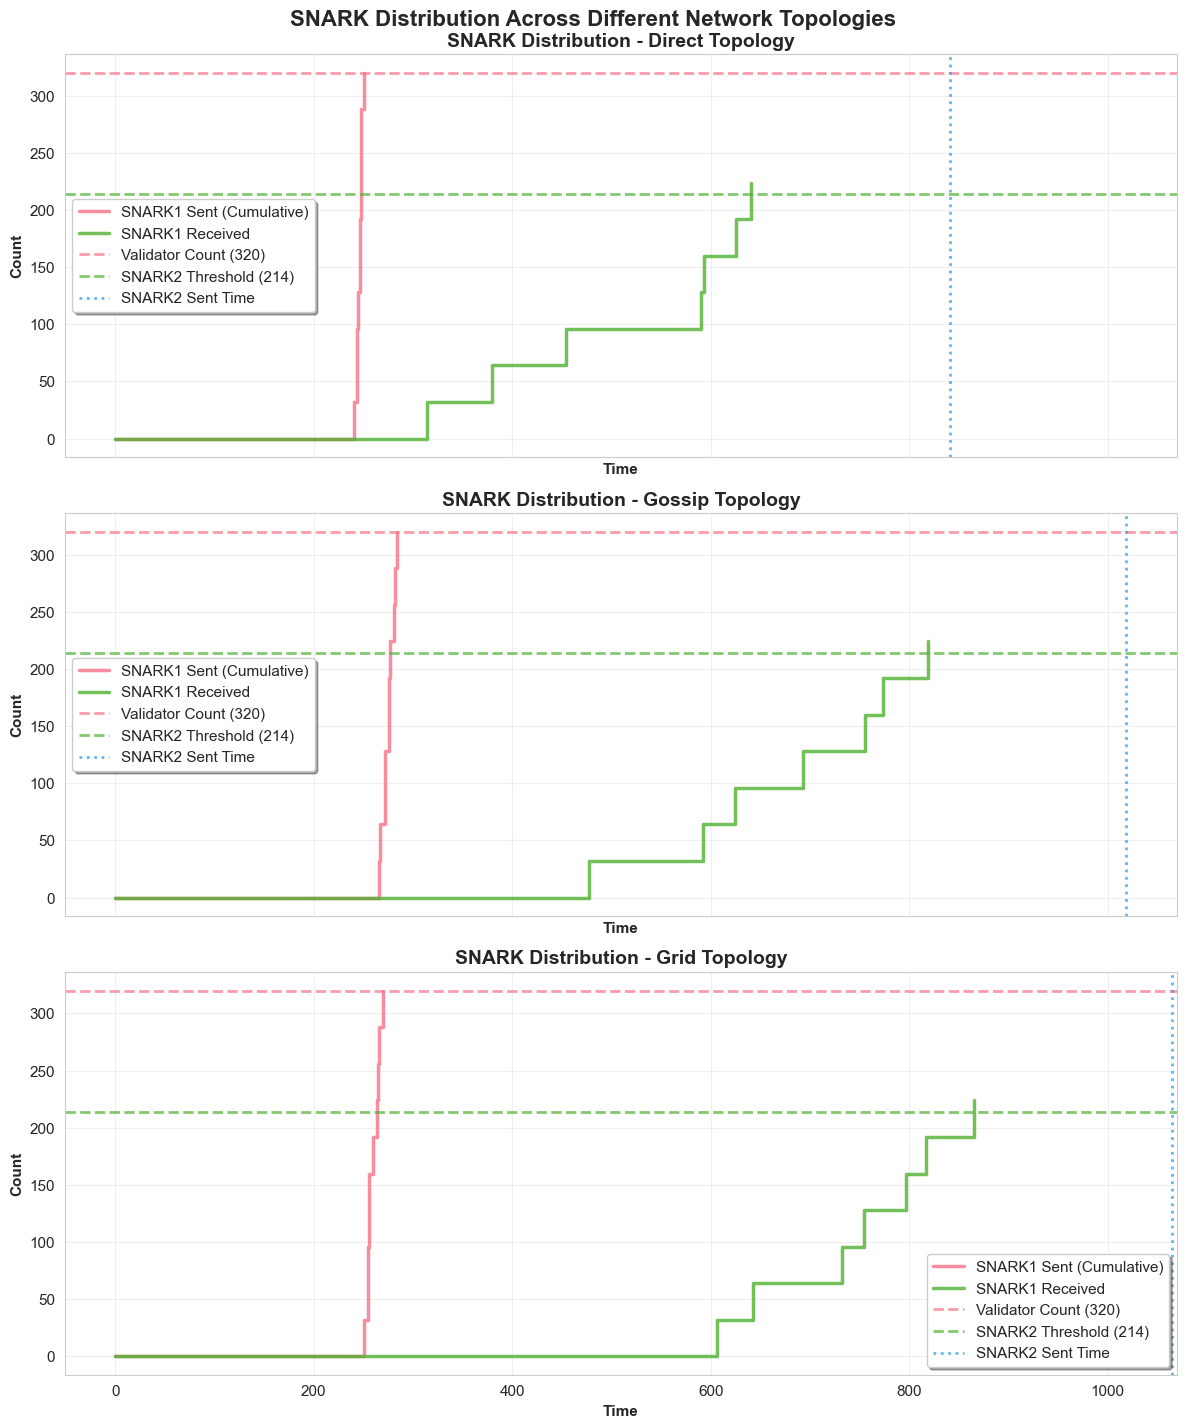

In [2]:
def plot1(items, ax: plt.Axes = None, topology_name=""):
    _, _, validator_count, snark2_threshold = beamsim.filter_report(items, "info")[0]
    snark1_sent = beamsim.filter_report(items, "snark1_sent")
    snark1_received = beamsim.get_snark1_received(items)
    snark2_sent = beamsim.filter_report(items, "snark2_sent")

    show = ax is None
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Use seaborn color palette
    colors = sns.color_palette("husl", 3)
    
    # Plot with enhanced styling
    ax.step(
        [0, *beamsim.time_axis(snark1_sent)],
        [0, *np.cumsum([x[2] for x in snark1_sent])],
        where="post",
        color=colors[0],
        linewidth=2.5,
        label="SNARK1 Sent (Cumulative)",
        alpha=0.8
    )
    ax.step(
        [0, *beamsim.time_axis(snark1_received)],
        [0, *[x[2] for x in snark1_received]],
        where="post",
        color=colors[1],
        linewidth=2.5,
        label="SNARK1 Received",
        alpha=0.8
    )
    
    # Enhanced reference lines
    ax.axhline(validator_count, linestyle="--", color=colors[0], 
               alpha=0.7, linewidth=2, label=f"Validator Count ({validator_count})")
    ax.axhline(snark2_threshold, linestyle="--", color=colors[1], 
               alpha=0.7, linewidth=2, label=f"SNARK2 Threshold ({snark2_threshold})")
    
    if snark2_sent:
        ax.axvline(snark2_sent[0][0], linestyle=":", color=colors[2], 
                   alpha=0.8, linewidth=2, label="SNARK2 Sent Time")
    
    # Enhanced styling
    ax.set_xlabel("Time", fontweight='bold')
    ax.set_ylabel("Count", fontweight='bold')
    if topology_name:
        ax.set_title(f"SNARK Distribution - {topology_name.title()} Topology", 
                     fontweight='bold', fontsize=14)
    
    ax.legend(frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3)
    
    if show:
        plt.tight_layout()
        plt.show()


# Create enhanced subplots with better spacing
fig, axes = plt.subplots(nrows=3, figsize=(12, 15), sharex=True)
fig.suptitle("SNARK Distribution Across Different Network Topologies", 
             fontsize=16, fontweight='bold', y=0.95)

plot1(beamsim.run(t="direct", b="ns3-direct", g=10, gv=32, mpi=10), axes[0], "Direct")
plot1(beamsim.run(t="gossip", b="ns3-direct", g=10, gv=32, mpi=10), axes[1], "Gossip")
plot1(beamsim.run(t="grid", b="ns3-direct", g=10, gv=32, mpi=10), axes[2], "Grid")

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

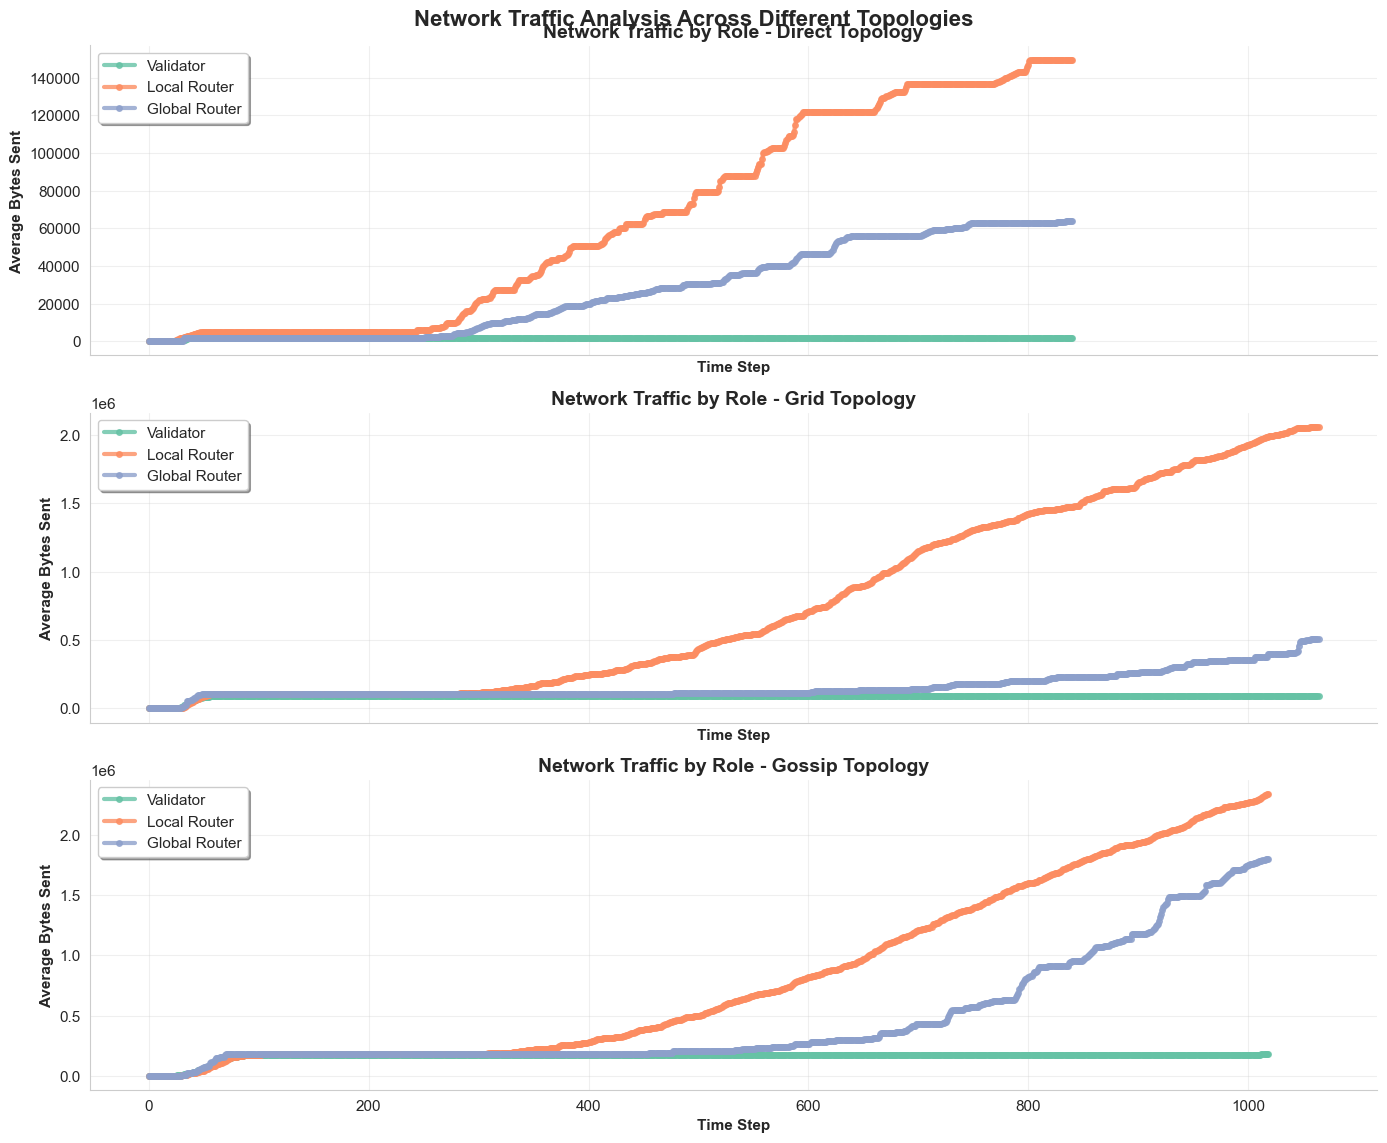

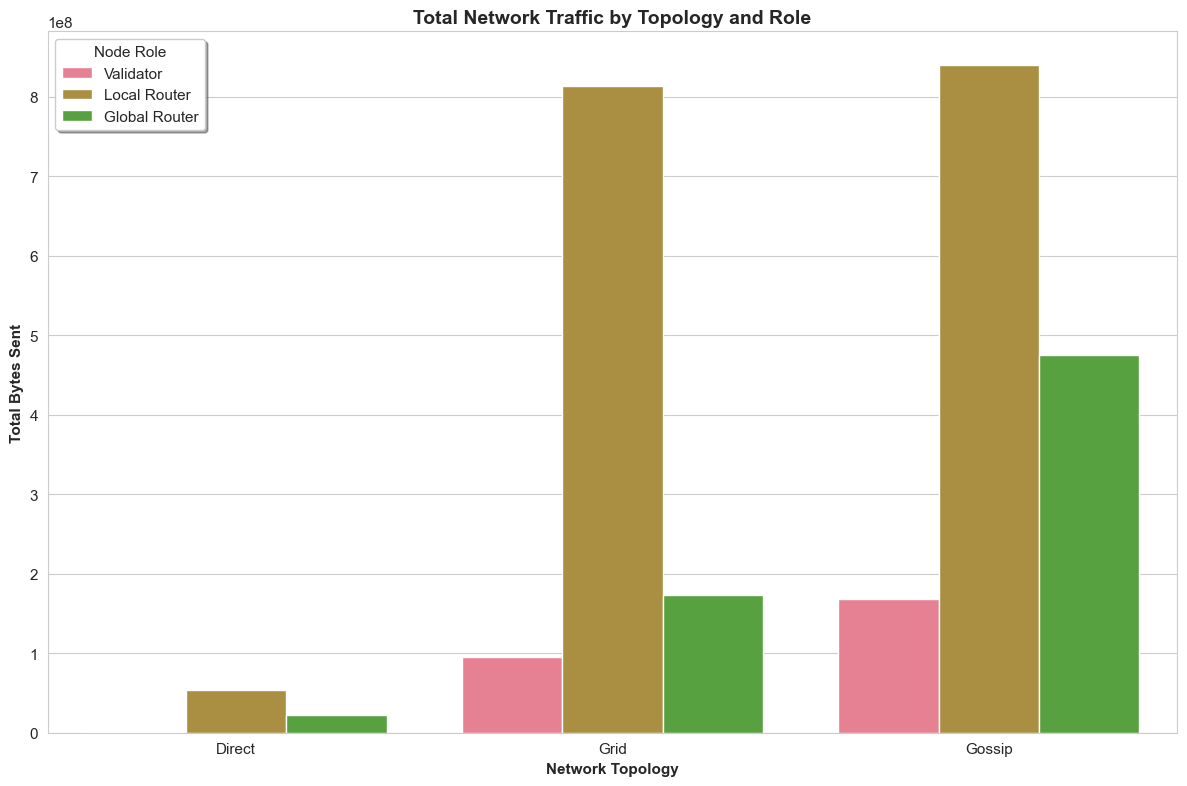

In [3]:
def plot2(items, ax=None, topology_name=""):
    metrics = beamsim.Metrics(items)
    
    show = ax is None
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create a more structured data approach
    time_points = range(metrics.t)
    roles = ["Validator", "Local Router", "Global Router"]
    colors = sns.color_palette("Set2", 3)
    
    for i, (y, label, color) in enumerate(zip(metrics.bytes_sent_role_avg, roles, colors)):
        ax.plot(time_points, y, label=label, linewidth=3, 
                color=color, marker='o', markersize=4, alpha=0.8)
    
    ax.set_xlabel("Time Step", fontweight='bold')
    ax.set_ylabel("Average Bytes Sent", fontweight='bold')
    if topology_name:
        ax.set_title(f"Network Traffic by Role - {topology_name} Topology", 
                     fontweight='bold', fontsize=14)
    
    ax.legend(frameon=True, fancybox=True, shadow=True, loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # Add some styling enhancements
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if show:
        plt.tight_layout()
        plt.show()


# Create a comprehensive comparison plot
fig, axes = plt.subplots(nrows=3, figsize=(14, 12), sharex=True)
fig.suptitle("Network Traffic Analysis Across Different Topologies", 
             fontsize=16, fontweight='bold', y=0.95)

# Run simulations and plot
topologies = ["Direct", "Grid", "Gossip"]
topology_params = ["direct", "grid", "gossip"]

for i, (topo_name, topo_param) in enumerate(zip(topologies, topology_params)):
    items = beamsim.run(t=topo_param, b="ns3-direct", g=10, gv=32, mpi=10)
    plot2(items, axes[i], topo_name)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Additional: Create a summary comparison plot
fig, ax = plt.subplots(figsize=(12, 8))

# Collect data for all topologies
all_data = []
for topo_name, topo_param in zip(topologies, topology_params):
    items = beamsim.run(t=topo_param, b="ns3-direct", g=10, gv=32, mpi=10)
    metrics = beamsim.Metrics(items)
    
    # Calculate total bytes sent for each role
    total_bytes = [sum(role_data) for role_data in metrics.bytes_sent_role_avg]
    
    for role_idx, (role, total) in enumerate(zip(["Validator", "Local Router", "Global Router"], total_bytes)):
        all_data.append({
            'Topology': topo_name,
            'Role': role,
            'Total Bytes Sent': total
        })

# Create DataFrame and plot
df = pd.DataFrame(all_data)
sns.barplot(data=df, x='Topology', y='Total Bytes Sent', hue='Role', ax=ax)
ax.set_title("Total Network Traffic by Topology and Role", fontweight='bold', fontsize=14)
ax.set_ylabel("Total Bytes Sent", fontweight='bold')
ax.set_xlabel("Network Topology", fontweight='bold')
plt.xticks(rotation=0)
plt.legend(title='Node Role', frameon=True, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()